In [4]:
import pandas as pd
import csv
import os
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from datasets import load_from_disk
from IPython.display import display
from datasets import Dataset, ClassLabel
from datetime import datetime

from llm_mri import Metrics
from utils import get_metric_function, merge_data_from_dicts

## Utils

In [5]:
# Constants
GRID_SIZES = [10, 20, 30, 40, 50]
SAMPLE_SIZE = 1000

# Paths
fakenews_data_path = "../data/fakenews"
processed_graphs_path = f"{fakenews_data_path}/processed/graphs"
results_path = f"{fakenews_data_path}/results"
metrics_path = f"{results_path}/metrics.csv"

model_ckpt = "distilbert/distilbert-base-multilingual-cased"

## Número de nós por camada

### Get Metrics per Layer

In [6]:
# Limpa o arquivo existente
metrics_per_layers_path = f"{results_path}/metrics_per_layers.json"
# Remove o arquivo se existir, depois cria um novo vazio
if os.path.exists(metrics_per_layers_path):
    os.remove(metrics_per_layers_path)
with open(metrics_per_layers_path, "w") as f:
    pass


final_metrics = dict()

for grid_size in GRID_SIZES:
    final_metrics[grid_size] = dict()
    
    for label_type  in ["true", "fake"]:
        final_metrics[grid_size][label_type] = dict()

        for metric_name, metric_func in get_metric_function().items():
        
            general_metric_per_layer = dict()
            
            # for sample in range(SAMPLE_SIZE):
            for sample in range(10):

                current_graph = nx.read_gexf(f"{processed_graphs_path}/{grid_size}/g_{label_type}_{sample}.gexf")

                # Get degree per layer
                current_metric_per_layer = metric_func(current_graph)
                general_metric_per_layer = merge_data_from_dicts(
                    general_metric_per_layer, current_metric_per_layer
                )

            # Calculate mean and standard error per layer
            metric_means = {}
            metric_stderr = {}
            for layer, metrics in general_metric_per_layer.items():
                
                metric_means[layer] = np.mean(metrics)
                metric_stderr[layer] = np.std(metrics) / np.sqrt(len(metrics))

            # Store metrics for the current group
            final_metrics[grid_size][label_type][metric_name] = {
                k: {
                    "mean": metric_means[k],
                    "stderr": metric_stderr[k],
                }
                for k in metric_means.keys()
            }


with open(
    metrics_per_layers_path,
    "w",
) as f:
    json.dump(final_metrics, f)

### Plot Results per Layer

In [7]:
# Load metrics per layers data
with open(metrics_per_layers_path, "r") as f:
    metrics_per_layers_data = json.load(f)

print("Dados carregados com sucesso!")
print(f"Grid sizes disponíveis: {list(metrics_per_layers_data.keys())}")
print(f"Métricas disponíveis: {list(metrics_per_layers_data['10']['true'].keys())}")


Dados carregados com sucesso!
Grid sizes disponíveis: ['10', '20', '30', '40', '50']
Métricas disponíveis: ['degree_per_layer', 'num_nodes_per_layer', 'num_edges_per_layer']



Grid Size: 10
Plotting num_nodes_per_layer...


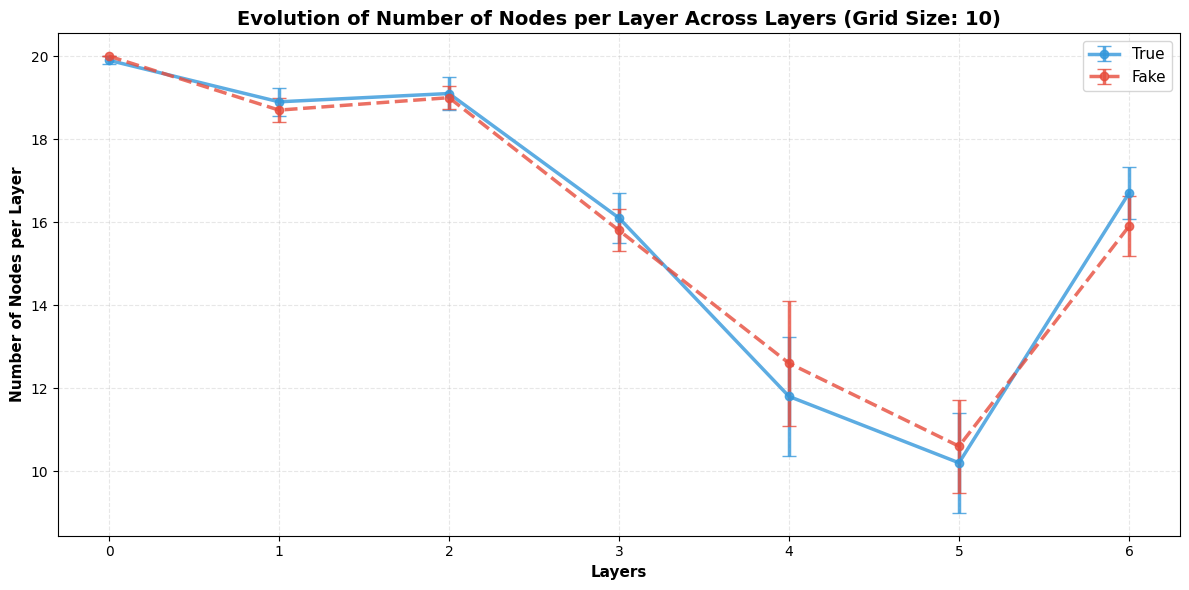


Grid Size: 20
Plotting num_nodes_per_layer...


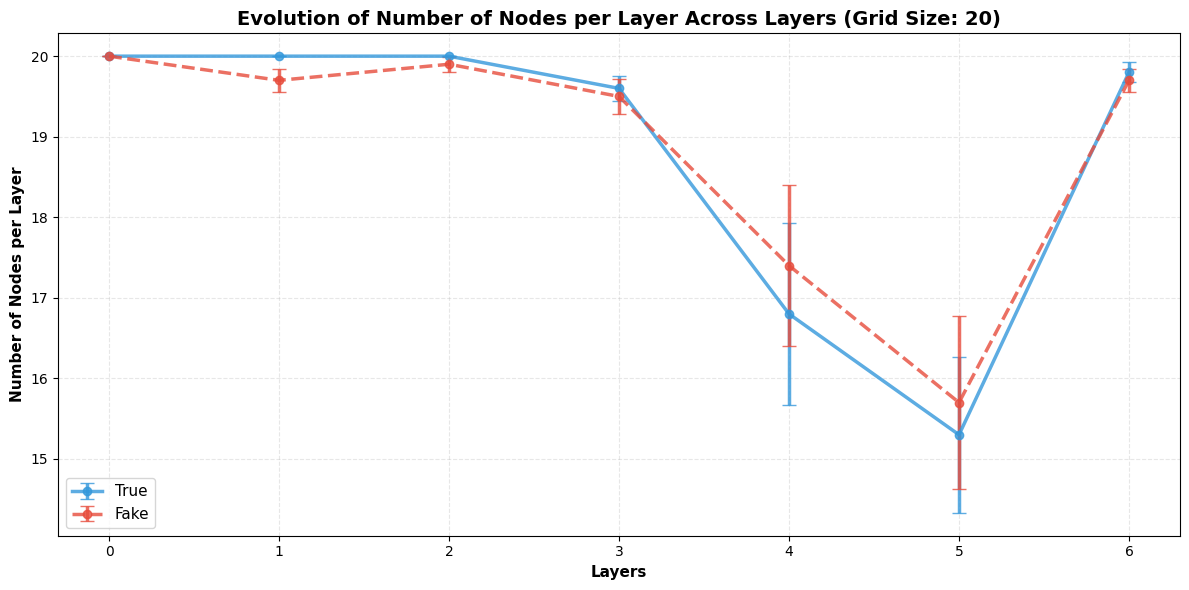


Grid Size: 30
Plotting num_nodes_per_layer...


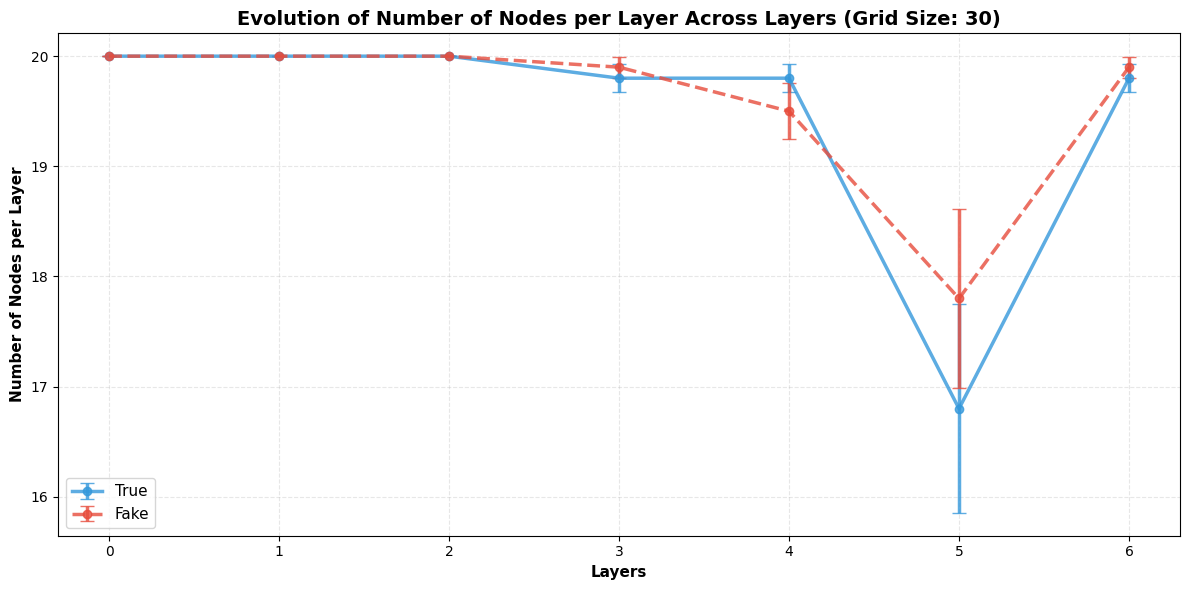


Grid Size: 40
Plotting num_nodes_per_layer...


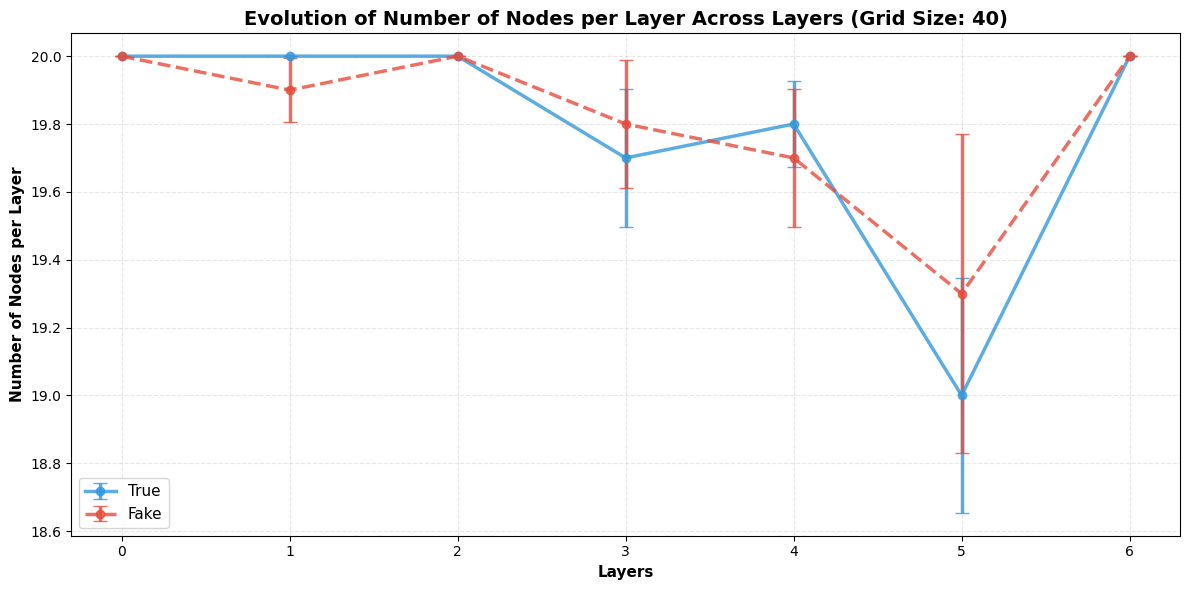


Grid Size: 50
Plotting num_nodes_per_layer...


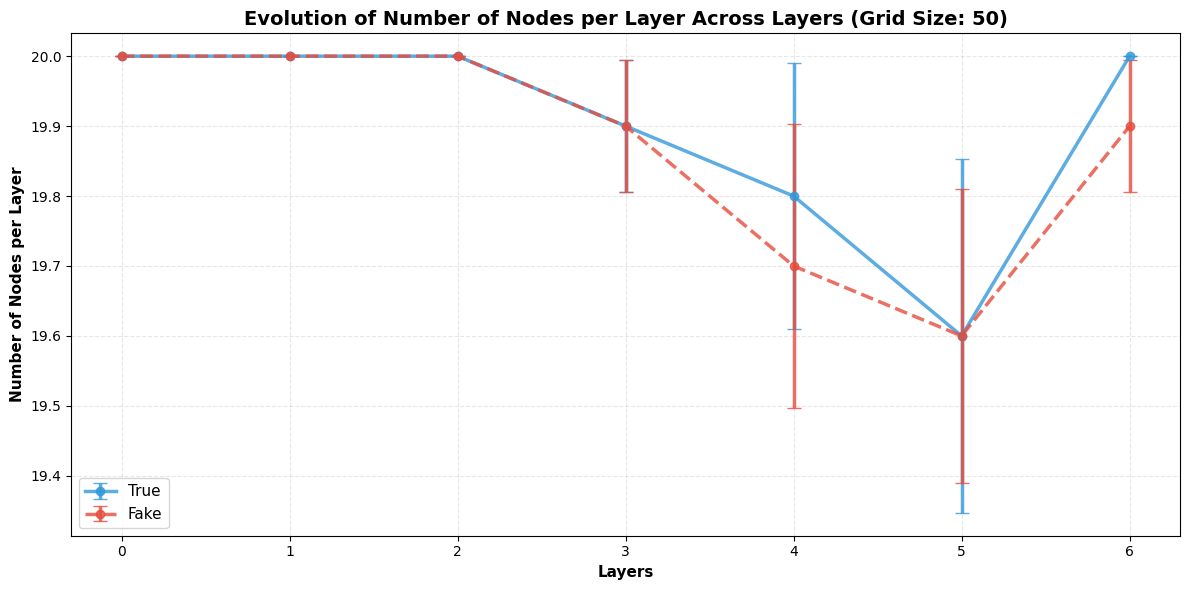

In [8]:
def plot_layer_evolution(data, grid_size, metric_name, ylabel=None):
    """
    Plot the evolution of a metric across layers for a specific grid size.
    Shows two lines: one for 'true' and one for 'fake' labels.
    
    Args:
        data: Data loaded from metrics_per_layers.json
        grid_size: Grid size to plot
        metric_name: Name of the metric to plot ('degree_per_layer', 'num_nodes_per_layer', 'num_edges_per_layer')
        ylabel: Label for y-axis (if None, uses metric_name)
    """
    plt.figure(figsize=(12, 6))
    
    # Define colors for each label type
    colors = {
        "true": "#3498db",
        "fake": "#e74c3c"
    }
    
    # Define line styles
    linestyles = {
        "true": "-",
        "fake": "--"
    }
    
    # Iterate over label types (true and fake)
    for label_type in ["true", "fake"]:
        metric_data = data[grid_size][label_type][metric_name]
        
        # Extract layers, means, and standard errors
        # For num_edges_per_layer, the keys are like "0>>1", "1>>2", etc.
        # For degree_per_layer and num_nodes_per_layer, keys are layer numbers
        
        # Sort layers appropriately
        if metric_name == "num_edges_per_layer":
            # For edges, sort by first layer number
            sorted_layers = sorted(metric_data.keys(), key=lambda x: int(x.split(">>")[0]))
        else:
            # For nodes and degree, sort numerically
            sorted_layers = sorted(metric_data.keys(), key=lambda x: int(x))
        
        means = [metric_data[layer]["mean"] for layer in sorted_layers]
        stderrs = [metric_data[layer]["stderr"] for layer in sorted_layers]
        
        # Plot with error bars
        plt.errorbar(
            sorted_layers,
            means,
            yerr=stderrs,
            label=f"{label_type.capitalize()}",
            capsize=5,
            color=colors[label_type],
            linestyle=linestyles[label_type],
            linewidth=2.5,
            marker='o',
            markersize=6,
            alpha=0.8
        )
    
    # Set labels and title
    if ylabel is None:
        ylabel = metric_name
    
    plt.title(f"Evolution of {ylabel} Across Layers (Grid Size: {grid_size})", fontsize=14, fontweight='bold')
    plt.xlabel("Layers", fontweight='bold', fontsize=11)
    plt.ylabel(ylabel, fontweight='bold', fontsize=11)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


# Define metric display names
metric_labels = {
    # "degree_per_layer": "Mean Degree per Layer",
    "num_nodes_per_layer": "Number of Nodes per Layer",
    # "num_edges_per_layer": "Number of Edges per Layer"
}

# Plot for each grid size and each metric
for grid_size in GRID_SIZES:
    print(f"\n{'='*60}")
    print(f"Grid Size: {grid_size}")
    print(f"{'='*60}")
    
    
    # for metric_name in get_metric_function().keys():
    for metric_name in ["num_nodes_per_layer"]:
        print(f"Plotting {metric_name}...")
        ylabel = metric_labels.get(metric_name, metric_name)
        plot_layer_evolution(metrics_per_layers_data, str(grid_size), metric_name, ylabel)
